In [1]:
from modules._models_v2 import PoissonPinn, create_dense_model
from modules.data import simulate_poisson
from modules.plots import plot_training_loss_linlog, plot_poisson_model
import tensorflow as tf
import numpy as np

2022-12-26 23:34:24.897357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
a = 4

def u(x):
  return tf.sin(np.pi * a * x)

def u_xx(x): # rhs function
  return -(np.pi * a)**2 * tf.sin(np.pi * a * x)

In [3]:
(x_eqn, rhs_eqn), (x_bnd, u_bnd) = simulate_poisson(1000, u_xx, u)

2022-12-26 23:34:29.595601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 23:34:29.716688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 23:34:29.717033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 23:34:29.720384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [4]:
inputs = [x_eqn, x_bnd]
outputs = [u(x_eqn), rhs_eqn, u_bnd]

In [5]:
backbone = create_dense_model(layers=[128]*3, activation='tanh', \
    initializer=tf.keras.initializers.GlorotNormal(seed=10), n_inputs=1, n_outputs=1)


In [6]:
pinn = PoissonPinn(backbone)

In [7]:
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 500, 0.92)
optimizer = tf.keras.optimizers.Adam(scheduler)
pinn.compile(optimizer=optimizer)

In [8]:
history = pinn.fit(inputs, outputs, epochs=20000, batch_size=200, verbose=0)

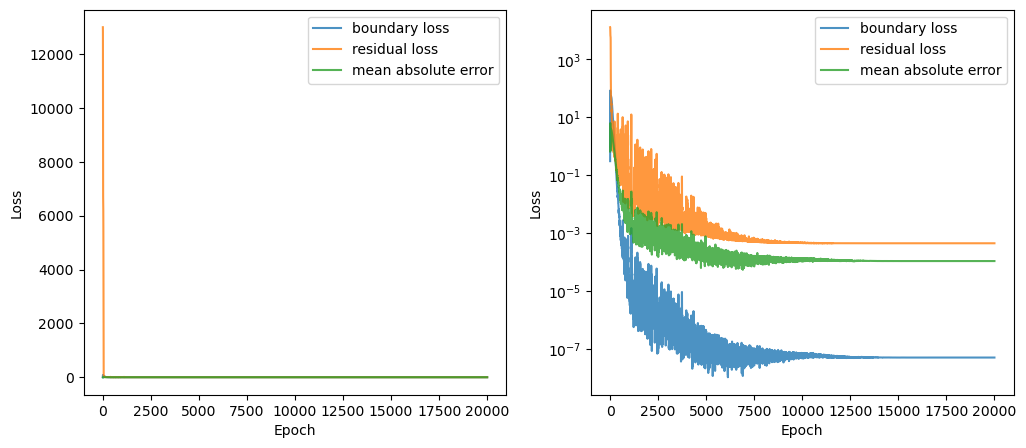

In [9]:
plot_training_loss_linlog(history.history)

1/1 [==============================] - 0s 150ms/step


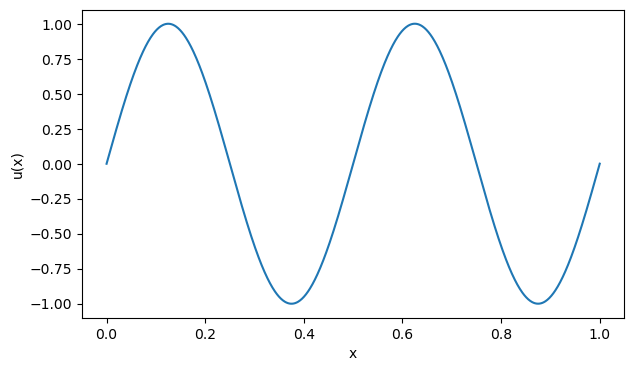

In [11]:
plot_poisson_model(pinn.backbone, 0, 1)

In [12]:
from modules.plots import plot_pointwise_error

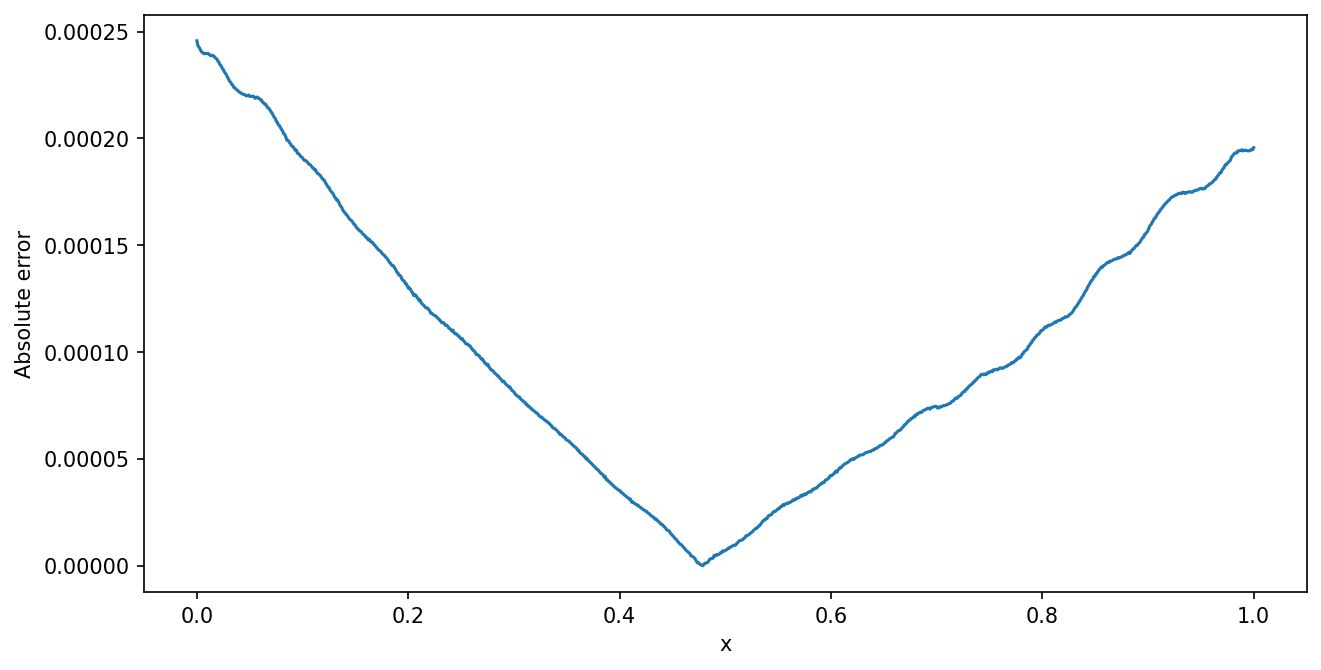

In [27]:
x = tf.linspace(0, 1, 1000)
# to float
x = tf.cast(x, tf.float32)
u_exact = u(x)
u_approx = pinn.backbone(x)[:, 0]
plot_pointwise_error(u_exact, u_approx, x)